In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size()[0], -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [6]:
def train_and_collect():
    all_weights_fc1, all_weights_full, all_losses = [], [], []
    for i in range(8):  # Train the model 8 times
        model = Net()
        print("Training "+str(i+1)+" time.")
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        weights_fc1, weights_full, losses = [], [], []
        for epoch in range(24):  # Collect weights every 3 epochs
            for images, labels in train_loader:
                optimizer.zero_grad()
                output = model(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
            if epoch % 3 == 0:
                weights_fc1.append(model.fc1.weight.data.numpy().flatten())
                full_weights = np.concatenate([param.data.numpy().flatten() for param in model.parameters()])
                weights_full.append(full_weights)
                losses.append(loss.item())
        all_weights_fc1.append(weights_fc1)
        all_weights_full.append(weights_full)
        all_losses.append(losses)
    return all_weights_fc1, all_weights_full, all_losses

In [7]:
weights_fc1_collected, weights_full_collected, losses_collected = train_and_collect()

Training 1 time.
Training 2 time.
Training 3 time.
Training 4 time.
Training 5 time.
Training 6 time.
Training 7 time.
Training 8 time.


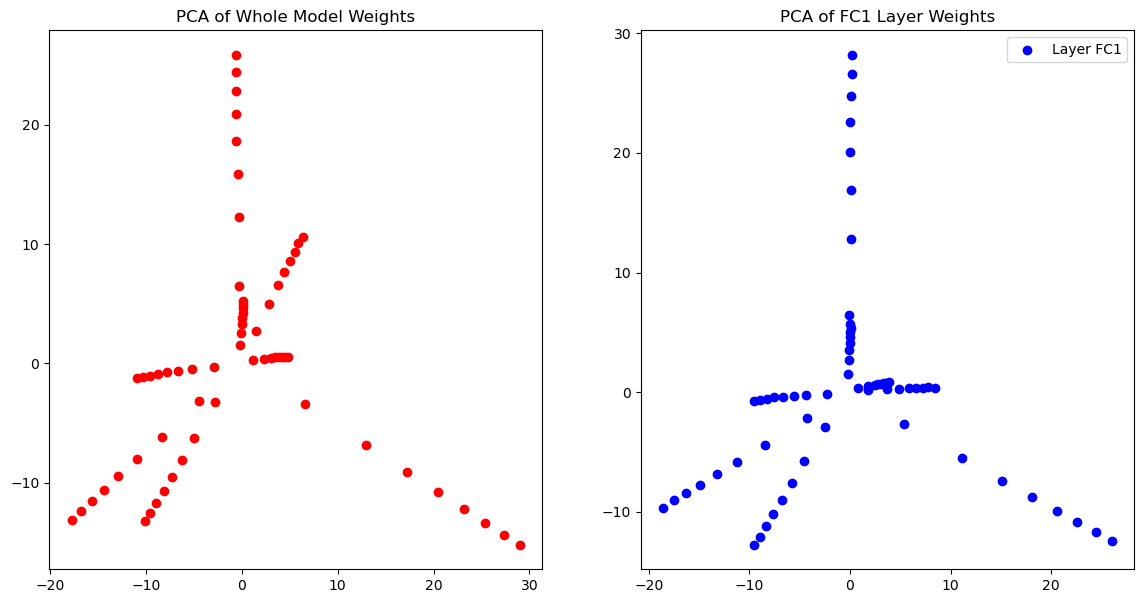

In [8]:
weights_full_flat = np.vstack(weights_full_collected)

# PCA Reduction
pca_full = PCA(n_components=2)

weights_full_pca = pca_full.fit_transform(weights_full_flat)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# Plot for whole model
axs[0].scatter(weights_full_pca[:, 0], weights_full_pca[:, 1], c='red', label='Whole Model')
axs[0].set_title('PCA of Whole Model Weights')

weights_fc1_flat = np.vstack(weights_fc1_collected)
pca_fc1 = PCA(n_components=2)
weights_fc1_pca = pca_fc1.fit_transform(weights_fc1_flat)

# Plot for one layer
axs[1].scatter(weights_fc1_pca[:, 0], weights_fc1_pca[:, 1], c='blue', label='Layer FC1')
axs[1].set_title('PCA of FC1 Layer Weights')

plt.legend()
plt.show()
